In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Restructure the dataset as a user-focussed dataset

In [18]:
# read in the file
user_info = pd.read_json('Datasets/IDEA/dataset/user_new.json')

user_info = user_info.to_dict(orient='records')


## Extract Useful Information

- average duration 
- average max scroll percentage
- time of the day access the news 

In [19]:
from datetime import datetime

def compute_average(values):
    values = np.array(values)
    if values.size == 0:
        return np.nan
    if np.unique(values).size == 1:
        return float(values[0])
    lower = np.percentile(values, 1)
    upper = np.percentile(values, 99)
    filtered = values[(values > lower) & (values < upper)]
    if filtered.size == 0:
        # if all values are outliers, return the mean of the original values
        return np.mean(values)
    return np.mean(filtered)

user_heur_list = []

for user in tqdm.tqdm(user_info, total=len(user_info)):
    user_heur = {}
    user_id = user['informfully_id']
    user_heur['informfully_id'] = user_id
    
    interactions = user.get('interactions', [])

    if not interactions:
        user_heur['avg_duration'] = np.nan
        user_heur['avg_maxscroll'] = np.nan
        user_heur['avg_time_per_scroll'] = np.nan
        user_heur['durations and maxscrolls'] = []
        user_heur['avg_weekday_time_accessing_article'] = np.nan
        user_heur['var_weekday_time_accessing_article'] = np.nan
        user_heur['time_accessing_article'] = []
        user_heur['time_accessing_article_seconds'] = []
        user_heur['avg_time_accessing_article'] = np.nan
        user_heur_list.append(user_heur)
        continue

    duration_list = [x.get('duration', 0) for x in interactions]
    maxscroll_list = [x.get('maxScrolledContent', 0) for x in interactions]

    time_per_scroll_list = []
    for dur, scroll in zip(duration_list, maxscroll_list):
        if scroll > 0:
            time_per_scroll_list.append(dur / (scroll * 100))

    avg_duration = compute_average(duration_list)
    avg_maxscroll = compute_average(maxscroll_list)
    avg_time_per_scroll = compute_average(time_per_scroll_list)

    time_access_list = []
    time_access_list_str = []
    for entry in interactions:
        created_at = entry.get('createdAt', '')
        try:
            date_str = created_at.split(' ')[0]
            # calculate if the day is a weekday or weekend
            weekday_or_weekend = datetime.strptime(date_str, '%Y-%m-%d').weekday()
            time_str = created_at.split(' ')[1]
            h, m, s = map(int, time_str.split(':'))
            total_seconds = h * 3600 + m * 60 + s
            time_access_list.append((total_seconds, weekday_or_weekend))
            time_access_list_str.append(time_str+' '+str(weekday_or_weekend))
        except (IndexError, ValueError):
            continue

    weekday_time_access = [x[0] for x in time_access_list if x[1] in range(5)]
    avg_time_access = compute_average(weekday_time_access)
    var_time_access = np.var([x/60 for x in weekday_time_access if not np.isnan(x)])

    avg_time_access_list = np.mean([x[0] for x in time_access_list])
    
    user_heur['avg_duration'] = avg_duration
    user_heur['avg_maxscroll'] = avg_maxscroll
    user_heur['avg_time_per_scroll'] = avg_time_per_scroll
    user_heur['durations and maxscrolls'] = list(zip(duration_list, maxscroll_list, time_per_scroll_list))
    user_heur['avg_weekday_time_accessing_article'] = avg_time_access
    user_heur['var_weekday_time_accessing_article'] = var_time_access
    user_heur['time_accessing_article'] = time_access_list_str
    user_heur['time_accessing_article_seconds'] = time_access_list
    user_heur['avg_time_accessing_article'] = avg_time_access_list
    user_heur_list.append(user_heur)

    # write to log file
    with open('user_heuristic' + datetime.now().strftime('%Y%m%d%H%M%S') + '.log', 'a') as log_file:
        log_file.write(f'User ID: {user_id}\n')
        log_file.write(f'Average duration time: {avg_duration}\n')
        log_file.write(f'Average maxscroll: {avg_maxscroll}\n')
        log_file.write(f'Average time per percentage scroll: {avg_time_per_scroll}\n')
        avg_time_access_int = int(avg_time_access) if not np.isnan(avg_time_access) else np.nan
        if not np.isnan(avg_time_access_int):
            log_file.write(f'Average time accessing the article: {avg_time_access_int // 3600:02d}:{(avg_time_access_int % 3600) // 60:02d}:{avg_time_access_int % 60:02d}\n')
        else:
            log_file.write(f'Average time accessing the article: {avg_time_access}\n')
        log_file.write(f'Variance of time accessing the article: {var_time_access}\n')
        log_file.write('-------------------------------------\n')

import os

# create the directory if it does not exist
os.makedirs('Datasets/IDEA/dataset/log', exist_ok=True)

with open('Datasets/IDEA/dataset/log/user_heuristic.json', 'w') as file:
    json.dump(user_heur_list, file, indent=4)


 59%|█████▉    | 351/593 [00:00<00:00, 476.44it/s]d:\miniforge3\lib\site-packages\numpy\_core\fromnumeric.py:4318: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\miniforge3\lib\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\miniforge3\lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 593/593 [00:01<00:00, 486.47it/s]


## Priori Labeling the Users

### Prelabeling the data, labeling the users as a heuristics based on the time accessing the news

- rush_hour: 6:00 - 10:00 and 16:00 - 20:00

- bedtime: 22:00 - 6:00

- work_hour: 10:00 - 16:00 in the weekdays

- weekend: 9:00 - 17:00 in the weekends


#### or based on the duration of reading the news

- shallow: less than 1 minute, or the max scroll is less than 25%

- medium: 1 - 5 minutes, or the max scroll is 25% - 75%

- deep: more than 5 minutes, or the max scroll is more than 75%

In [20]:
'''
iterating through the dataset and add heuristic features to the user_info dictionary:
# if any access time falls in the following time range, add the corresponding label to the user_info dictionary
- rush_hour: 6:00 - 10:00 and 16:00 - 20:00 in the weekdays

- bedtime: 22:00 - 6:00

- work_hour: 10:00 - 16:00 in the weekdays

- weekend: 9:00 - 17:00 in the weekends

# if the user has duration and maxscroll data falls in the following range, add the corresponding label to the user_info dictionary
- shallow: less than 1 minute, or the max scroll is less than 25%

- medium: 1 - 5 minutes, or the max scroll is 25% - 75%

- deep: more than 5 minutes, or the max scroll is more than 75%
'''

user_heur_list = pd.read_json('Datasets/IDEA/dataset/user_heuristic.json')

user_heur_list = user_heur_list.to_dict(orient='records')

for user in tqdm.tqdm(user_heur_list, total=len(user_heur_list)):
    user_id = user['informfully_id']
    user['access_time_label'] = {'rush_hour': 0, 'bedtime': 0, 'work_hour': 0, 'weekend': 0}
    user['duration_maxscroll_label'] = {'shallow': 0, 'medium': 0, 'deep': 0}

    for time in user['time_accessing_article_seconds']:
        if time[1] in range(5):
            if 6 * 3600 <= time[0] <= 10 * 3600 or 16 * 3600 <= time[0] <= 20 * 3600:
                user['access_time_label']['rush_hour'] += 1
            elif 22 * 3600 <= time[0] <= 6 * 3600:
                user['access_time_label']['bedtime'] += 1
            elif 10 * 3600 <= time[0] <= 16 * 3600:
                user['access_time_label']['work_hour'] += 1
        else:
            if 9 * 3600 <= time[0] <= 17 * 3600:
                user['access_time_label']['weekend'] += 1

    for duration, maxscroll, _ in user['durations and maxscrolls']:
        if duration < 60 or maxscroll*100 < 25:
            user['duration_maxscroll_label']['shallow'] += 1
        elif 60 <= duration <= 300 or 25 <= maxscroll*100 <= 75:
            user['duration_maxscroll_label']['medium'] += 1
        else:
            user['duration_maxscroll_label']['deep'] += 1
            
with open('Datasets/IDEA/dataset/user_heuristic_labeled.json', 'w') as file:
    json.dump(user_heur_list, file, indent=4)

100%|██████████| 593/593 [00:00<00:00, 18960.67it/s]


In [21]:
user_heuristic_labeled = pd.read_json('Datasets/IDEA/dataset/user_heuristic_labeled.json')

# filter out the list data 
user_heuristic_labeled = user_heuristic_labeled.to_dict(orient='records')

user_heuristic_labeled_filtered = []
for user in user_heuristic_labeled:
    user_filtered = {}
    user_filtered['informfully_id'] = user['informfully_id']
    user_filtered['avg_duration'] = user['avg_duration']
    user_filtered['avg_maxscroll'] = user['avg_maxscroll']
    user_filtered['avg_time_per_scroll'] = user['avg_time_per_scroll']
    user_filtered['avg_weekday_time_accessing_article'] = user['avg_weekday_time_accessing_article']
    user_filtered['var_weekday_time_accessing_article'] = user['var_weekday_time_accessing_article']   
    for key, value in user['access_time_label'].items():
        user_filtered[key] = value
    for key, value in user['duration_maxscroll_label'].items():
        user_filtered[key] = value
    
    user_heuristic_labeled_filtered.append(user_filtered)
    
user_heuristic_labeled_filtered = pd.DataFrame(user_heuristic_labeled_filtered)

user_heuristic_labeled_filtered.to_csv('Datasets/IDEA/dataset/user_heuristic_labeled_filtered.csv', index=False)

## Standardize the dataset

### for every user, the feature should be standardized, according to the average value of the given feature


In [22]:
user_heuristic_labeled_filtered = pd.read_csv('Datasets/IDEA/dataset/user_heuristic_labeled_filtered.csv')

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler with the data
scaler.fit(user_heuristic_labeled_filtered.iloc[:, 1:])

# Transform the data
user_heuristic_labeled_filtered_scaled = scaler.transform(user_heuristic_labeled_filtered.iloc[:, 1:])
user_heuristic_labeled_filtered_scaled = pd.DataFrame(user_heuristic_labeled_filtered_scaled, columns=user_heuristic_labeled_filtered.columns[1:])
user_heuristic_labeled_filtered_scaled.insert(0, 'informfully_id', user_heuristic_labeled_filtered['informfully_id'])

# Save the scaled data
user_heuristic_labeled_filtered_scaled.to_csv('Datasets/IDEA/dataset/user_heuristic_labeled_filtered_scaled.csv', index=False)


## Clustering the users

### KMeans Clustering

In [23]:
## Clustering using KMeans

# Load the scaled data
user_heuristic_labeled_filtered_scaled = pd.read_csv('Datasets/IDEA/dataset/user_heuristic_labeled_filtered_scaled.csv')

# Initialize the KMeans model
kmeans = KMeans(n_clusters=3, random_state=0)

# Fit the model, do not include the user has nan value
# Drop rows with any missing values
user_heuristic_labeled_filtered_scaled_clean = user_heuristic_labeled_filtered_scaled.dropna()

# Fit the model
kmeans.fit(user_heuristic_labeled_filtered_scaled_clean.iloc[:, 1:])

# Assign the cluster labels
user_heuristic_labeled_filtered_scaled['cluster'] = np.nan
user_heuristic_labeled_filtered_scaled.loc[user_heuristic_labeled_filtered_scaled_clean.index, 'cluster'] = kmeans.labels_

# Save the clustered data
user_heuristic_labeled_filtered_scaled.to_csv('Datasets/IDEA/dataset/user_heuristic_labeled_filtered_scaled_clustered.csv', index=False)

## Dimensionality reduction using PCA for visualization

In [25]:
# Load the clustered data
user_heuristic_labeled_filtered_scaled = pd.read_csv('Datasets/IDEA/dataset/user_heuristic_labeled_filtered_scaled_clustered.csv')

sth2add = pd.read_json('Datasets/IDEA/dataset/log/user_heuristic.json')

# Initialize the PCA model, set the number of components to 1
pca = PCA(n_components=1)

# fill the nan value with 0
user_heuristic_labeled_filtered_scaled.fillna(0, inplace=True)

# Fit the model
pca.fit(user_heuristic_labeled_filtered_scaled.iloc[:, 1:])
# Transform the data
user_heuristic_labeled_filtered_scaled_pca = user_heuristic_labeled_filtered_scaled
user_heuristic_labeled_filtered_scaled_pca['pca'] = pca.transform(user_heuristic_labeled_filtered_scaled.iloc[:, 1:])
user_heuristic_labeled_filtered_scaled_pca['alpha'] = sth2add['avg_time_accessing_article']

# Save the PCA data
user_heuristic_labeled_filtered_scaled_pca.to_csv('Datasets/IDEA/dataset/user_heuristic_labeled_filtered_scaled_pca.csv', index=False)


## simple visualization of the clusters

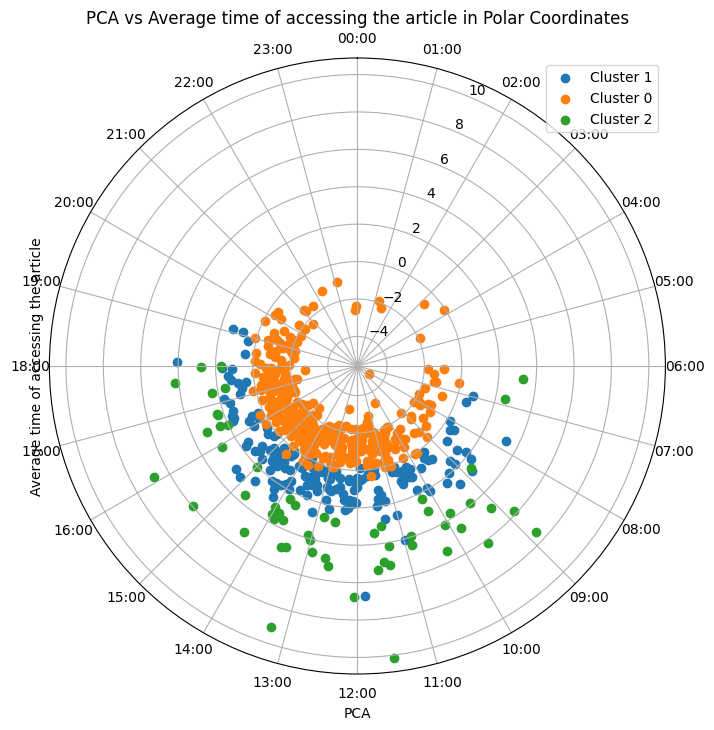

In [33]:
## Visualization as a circle whose radius is the PCA value and the angle is the average time of accessing the article

# Load the PCA data
user_heuristic_labeled_filtered_scaled_pca = pd.read_csv('Datasets/IDEA/dataset/user_heuristic_labeled_filtered_scaled_pca.csv')

# Initialize the figure
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Convert average time of accessing the article to radians
user_heuristic_labeled_filtered_scaled_pca['theta'] = np.deg2rad(user_heuristic_labeled_filtered_scaled_pca['alpha'] / 3600 / 24 * 360)

# Plot the data in polar coordinates
for cluster in user_heuristic_labeled_filtered_scaled_pca['cluster'].unique():
    data = user_heuristic_labeled_filtered_scaled_pca[user_heuristic_labeled_filtered_scaled_pca['cluster'] == cluster]
    ax.scatter(data['theta'], data['pca'], label=f'Cluster {int(cluster)}')

# Set custom x-ticks to represent time of day
hours = np.arange(0, 24, 1)
hour_labels = [f'{hour:02d}:00' for hour in hours]
ax.set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
ax.set_xticklabels(hour_labels)

# Rotate the plot to have 00:00 at the top
ax.set_theta_direction(-1)  # Clockwise
ax.set_theta_offset(np.pi / 2)  # 90 degrees offset

# Set the labels and title
ax.set_xlabel('PCA')
ax.set_ylabel('Average time of accessing the article')
ax.set_title('PCA vs Average time of accessing the article in Polar Coordinates')
ax.legend()
plt.show()

### Improvements made to the visualization

#### Core Visualization Improvements

##### Data

- The 2 axis of the polar plot should be better defined. the theta axis indicating the time accessing articles should not be simply defined as the average time. The radius axis indicating the 1-D Dimensionality Reduction result should have better input data.